In [12]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import kendalltau
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [13]:
'''Import data'''
#data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/phylum/abs_muskegon_phylum_5in10_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/order/rel_muskegon_order_otu_5in10.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/5in10/muskegon/muskegon_sampledata_5in10.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [14]:
index = target.Lake[target.Lake == 'Muskegon'].index

In [15]:
'''Set sample names as index and shuffle data'''

#Remove outlier samples:
#data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[index,'HNA.cells']
hna_rel = hna/target.loc[index,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[index,'LNA.cells']
lna_rel = lna/target.loc[index,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [16]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [17]:
fs_scores = pd.read_csv('Final/FS_Scores/Muskegon_fs_scores_HNA_5seq10_order.csv', index_col=0)
fs_scores.sort_values('RL score', ascending=False, inplace=True)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [18]:
kendall = np.zeros(len(otus))
p_kendall = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    kendall[i], p_kendall[i] = kendalltau(data_rel_clr.loc[index_prod,otus[i]],prod)
fs = pd.DataFrame(np.abs(kendall), index=otus, columns = ['kendall_prod'])
fs['p_kendall_prod'] = p_kendall
fs['kendall_significant_prod'] = np.where(fs.loc[otus,'p_kendall_prod']<0.05,'yes','no')

In [19]:
from statsmodels.sandbox.stats.multicomp import multipletests
fdr_bh = multipletests(p_kendall, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
fs['fdr_bh'] = fdr_bh[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False], dtype=bool)

In [20]:
fs_prod = pd.concat([fs_scores,fs], axis=1)
fs_prod.sort_values('p_kendall_prod', ascending=True, inplace=True)
display(fs_prod.iloc[:,4:])

,kendall significant,RL score,RL ranking,Boruta score,Boruta ranking,kendall_prod,p_kendall_prod,kendall_significant_prod,fdr_bh
Otu001059,no,0.312,51.0,0.001602,43,0.473684,0.003500,yes,0.119032
Otu000041,no,0.324,50.0,0.063512,1,0.463158,0.004302,yes,0.119032
Otu000007,yes,0.064,83.0,0.003017,23,0.463158,0.004302,yes,0.119032
Otu000075,yes,0.208,74.0,0.002753,25,0.442105,0.006424,yes,0.130644
Otu000320,yes,0.630,3.0,0.048175,1,0.421053,0.009444,yes,0.130644
Otu000192,no,0.424,25.0,0.001456,40,0.421053,0.009444,yes,0.130644
Otu000682,yes,0.718,1.0,0.032861,2,0.410526,0.011385,yes,0.134994
Otu000322,no,0.454,19.0,0.003388,21,0.389474,0.016356,yes,0.150837
Otu000184,yes,0.430,24.0,0.003610,21,0.389474,0.016356,yes,0.150837
Otu000060,yes,0.680,2.0,0.302370,1,0.378947,0.019492,yes,0.161782


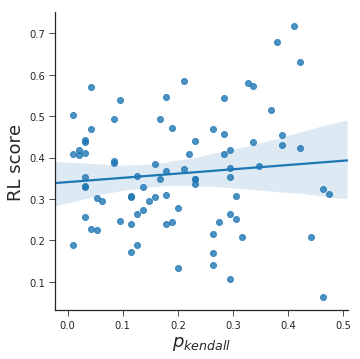

In [21]:
g = sns.lmplot(x='kendall_prod',y='RL score',data=fs_prod, fit_reg=True)
g.set_titles(size=22)
g.set_xlabels(r'$p_{kendall}$',fontsize=18)
g.set_ylabels(fontsize=18)
#g.fig.get_axes()[0].set_yscale('log')
plt.show()

In [22]:
fs.to_csv('Muskegon_fs_scores_HNA_5seq10_class_order.csv')